In [130]:
import numpy as np

import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp
from scipy.sparse import csr_matrix

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

from ecoli.processes.metabolism_redux import NetworkFlowModel, FlowResult

In [3]:
# jupyter autoreload modules

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [4]:
time = '10'
date = '2024-04-27'
experiment = 'convex_kinetics'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [5]:
output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [6]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [7]:
stoichiometry = agent['ecoli-metabolism-redux-classic'].stoichiometry
process_rxn_names = agent['ecoli-metabolism-redux-classic'].reaction_names
# maintenance_reaction = agent['ecoli-metabolism-redux-classic'].model.maintenance_reaction
# stoichiometry["maintenance_reaction"] = maintenance_reaction

bad_rxns = ["RXN-12440", "TRANS-RXN-121", "TRANS-RXN-300", "TRANS-RXN-8", "R15-RXN-MET/CPD-479//CPD-479/MET.25.","DISULFOXRED-RXN[CCO-PERI-BAC]-MONOMER0-4152/MONOMER0-4438//MONOMER0-4438/MONOMER0-4152.71."]
# generate carbon mistake in parca, efflux/influx proton gen, iron cheating, mass gen
# for rxn in bad_rxns:
#    stoichiometry.pop(rxn, None)


Pandas automatically understands dicts of dicts as matrices.

# Test changing nutrient composition

In [8]:
velocities = fba["estimated_fluxes"][4]
# use reaction names to make a dict
d_velocities = {k: v for k, v in zip(process_rxn_names, velocities)}

# Filter S matrix to only include nonzero fluxes.

In [9]:
# only include nonzero fluxes in solution.velocities
nonzero_velocities = {k: v for k, v in d_velocities.items() if v != 0}
nonzero_velocities

# reaction indices with nonzero fluxes
nonzero_S_indices = [process_rxn_names.index(k) for k in nonzero_velocities.keys()]

In [10]:
# Use nonzero_velocities to filter S matrix
S_matrix = stoichiometry[:, nonzero_S_indices]

# remove rows of S_used that sum to zero.
S_matrix = S_matrix[(S_matrix != 0).any(axis=1)]

In [11]:
S_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int8)

# First test. Single flux set. No eQuilibrator or regulation.

In [12]:
# sort nonzero_velocities to be in same order as S_matrix columns.
vE_dict = nonzero_velocities
vE = np.array([np.array(list(vE_dict.values()))])

In [13]:
Sd = pd.DataFrame(S_matrix, columns=[k for k in nonzero_velocities.keys()])
# Sd = pd.DataFrame(stoich_dict, dtype=np.int8).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]
Sr = None


Sd

,1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44. (reverse),1.8.4.8-RXN-3-5-ADP/SO3/Ox-thioredoxins-1/PROTON//PAPS/Red-thioredoxins-1.62. (reverse),1TRANSKETO-RXN,2-DEHYDROPANTOATE-REDUCT-RXN (reverse),2-ISOPROPYLMALATESYN-RXN,2-OCTAPRENYL-6-METHOXYPHENOL-HYDROX-RXN,2-OCTAPRENYL-6-OHPHENOL-METHY-RXN,2-OCTAPRENYL-METHOXY-BENZOQ-METH-RXN,2-OCTAPRENYLPHENOL-HYDROX-RXN,2.3.1.157-RXN,...,UDPGLUCEPIM-RXN,UDPHYDROXYMYRGLUCOSAMNACETYLTRANS-RXN,UDPKIN-RXN,UDPNACETYLGLUCOSAMACYLTRANS-RXN,UGD-RXN,URA-PHOSPH-RXN (reverse),UROGENDECARBOX-RXN,UROGENIIISYN-RXN,glycogen-monomer-extension,maintenance_reaction
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
from convex_kinetics_new import ConvexKineticsNew

In [100]:
E = ConvexKineticsNew()
y_f, y_r, y_s, y_p, y_i, y_a, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S_s_mol, S_p_mol, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE)

Number of metabolites: 466, number of reactions: 438, number of flux sets: 1
Number of Km_s: 927, number of Km_p: 1039, number of Km_i: None, number of Km_a: None
Number of concentrations: (466, 1), number of y_f: (1, 927), number of y_r: (1, 1039)


In [101]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

Shape of C_alpha: (1708, 927), shape of C_beta: (2294, 1039)
Shape of d_alpha: (1708,), shape of d_beta: (2294,)


In [102]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, d_beta, S_s_nz, S_p_nz, S, y_f, y_r, y_s, y_p, cfwd, crev)

In [103]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, LSE_expr, denom_expr)

In [104]:
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, lower_bound=-12, upper_bound=18)

In [105]:
problem = E.set_up_problem(loss, constr)


/Users/cyrus/.pyenv/versions/viv-10/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


In [106]:
solution = E.solve(problem)


In [107]:
solution.value

40.39801177888911

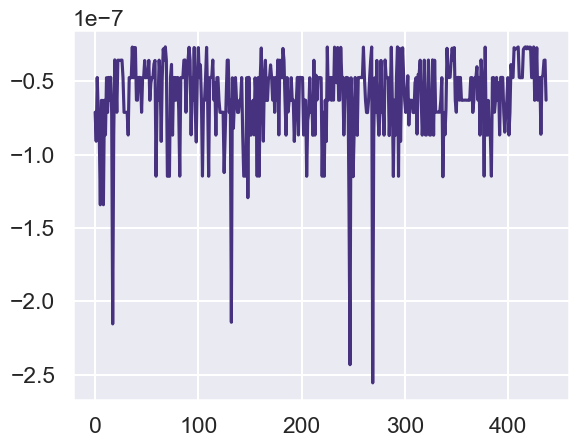

In [108]:
equality_constr = []

for v in LSE_expr:
    #print(v.value)
    equality_constr.append(logsumexp(v.value))
    
plt.plot(equality_constr)

# Solution-based recon

In [79]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

# Check fluxes

In [ ]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
# df_reconstr_comp



In [ ]:
# sort df_reconstr_comp by value
df_reconstr_comp = df_reconstr_comp.sort_values(by="value", ascending=False).reset_index(drop=True)

sns.catplot(y="variable", x="value", data=df_reconstr_comp, kind="bar", height=100, aspect=0.5)

# change x axis to log scale
plt.xscale('log')

# limit length of y axis labels to 20 characters
plt.gca().set_yticklabels([t.get_text()[:20] for t in plt.gca().get_yticklabels()])

# Simulation-structured recon

In [177]:
# pre rxn 
cn = np.array(c.value)[:, 0]
j = 0
i = -1

sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)
v_cur = np.zeros(n_rxn)

S_x = csr_matrix(S)
C_alpha_x = csr_matrix(C_alpha)
C_beta_x = csr_matrix(C_beta)

# define y vecs
y_s_t, y_p_t, y_i_t, y_a_t = [], [], [], []

# condense the code below into one line
y_s_t.append(np.multiply(S_s_mol, cn[met_s_nz] - Km_s.value))
y_p_t.append(np.multiply(S_p_mol, cn[met_p_nz] - Km_p.value))
y_i_t.append(cn[met_i_nz] - Km_i.value if Km_i else None)
y_a_t.append(-(cn[met_a_nz] - Km_a.value) if Km_a else None)

y_s = np.vstack(y_s_t).flatten()
y_p = np.vstack(y_p_t).flatten()
y_i = np.vstack(y_i_t).flatten()
y_a = np.vstack(y_a_t).flatten()

y_f_vec = [y_s]
y_r_vec = [y_p]
if Km_i:
    y_f_vec.append(y_i)
    y_r_vec.append(y_i)
if Km_a:
    y_f_vec.append(y_a)
    y_r_vec.append(y_a)

y_f_n = np.hstack(y_f_vec).flatten()
y_r_n = np.hstack(y_r_vec).flatten()


# now for each reaction in the set, calculate the saturation terms


In [178]:


for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]
    
    cur_sat =  (C_alpha_x @ y_f_n)[d_alpha == i].tolist() + \
                (C_beta_x @ y_r_n)[d_beta == i].tolist() + \
                [0],
    
    sat[i] = np.sum(np.exp(cur_sat))
    
    
    fwd_sat[i] = (np.exp(-S_x.T[i, S_s_idx] @ y_s[Km_s_idx])) # + cfwd.value[i]
    back_sat[i] = (np.exp(S_x.T[i, S_p_idx] @ y_p[Km_p_idx])) # + cfwd.value[i]

    
reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat

dmdt = S_x @ reconstr
